# Getting started with FastJet in Python

This notebook provides an introduction to the FastJet package in Python.

You can find the official documentation
[here](https://fastjet.readthedocs.io/en/latest/).

Furthermore, this notebook makes use of other packages from the
[Scikit-HEP](https://scikit-hep.org/) ecosystem, namely [Awkward
Array](https://awkward-array.org/) and
[Vector](https://vector.readthedocs.io/en/latest/).

## Installation

In order to be able to run this notebook, you need to install the
following packages:

```
awkward
numpy
matplotlib.pyplot
fastjet
vector
pandas
pathlib
subprocess
```

## Other tutorials you might want to look at

There are several nice tutorials on FastJet, Awkward Arrays and Vector, which you might want to look at:
- [Python background](https://hsf-training.github.io/hsf-training-scikit-hep-webpage/01-introduction/index.html)
- [Jagged, ragged, Awkward Arrays](https://hsf-training.github.io/hsf-training-scikit-hep-webpage/04-awkward/index.html)
- [Lorentz vectors, particle PDG, jet-clustering, oh my!](https://hsf-training.github.io/hsf-training-scikit-hep-webpage/06-lorentz-vectors/index.html)

In [1]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import fastjet as fj
import vector
import pandas as pd
import pathlib
import subprocess

vector.register_awkward()
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format='retina'

# define a function to sort ak.Array by pt
def sort_by_pt(data: ak.Array, ascending: bool = False):
    """Sort ak.Array by pt
    Args:
        data (ak.Array): array that should be sorted by pt. It should have a pt
            attribute.
        ascending (bool, optional): If True, the first value in each sorted
            group will be smallest; if False, the order is from largest to
            smallest. Defaults to False.
    Returns:
        ak.Array: sorted array
    """
    if isinstance(data, ak.Array):
        try:
            temppt = data.pt
        except AttributeError:
            raise AttributeError(
                "Needs either correct coordinates or embedded vector backend"
            )
    indices = ak.argsort(temppt, axis=-1, ascending=ascending)
    return data[indices]

## Downloading the dataset

We will use the [Top Quark Tagging Reference Dataset](https://zenodo.org/record/2603256) here.

In the cell below, we download the dataset and unzip it.

To do this on your own machine, you have to change the `dataset_path` variable
to a path where you want to store the dataset.
I recommend using something on `/beegfs/desy/user/<username>/` if you are at DESY.

In [2]:
# CHANGE THIS TO YOUR OWN PATH IF YOU WANT TO RUN THIS
dataset_path = pathlib.Path(
    "/beegfs/desy/user/birkjosc/testing/jet_clustering"
)

In [3]:
dataset_path.mkdir(parents=True, exist_ok=True)
subprocess.run(
    ["wget", "https://hqu.web.cern.ch/datasets/TopLandscape/TopLandscape.tar"],
    cwd=dataset_path,
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL,
)
subprocess.run(["tar", "-xf", "TopLandscape.tar"], cwd=dataset_path)

CompletedProcess(args=['tar', '-xf', 'TopLandscape.tar'], returncode=0)

We should now have the folder `TobLandscape` in the `dataset_path` directory.

In the cell below, we list the files in the `dataset_path` directory.

In [4]:
!ls -lh $dataset_path

total 2.3G
drwxr-xr-x 2 birkjosc unihh2    3 Mar 27  2022 TopLandscape
-rw-r--r-- 1 birkjosc unihh2 2.3G Mar 27  2022 TopLandscape.tar


You should see both the file `TopLandscape.tar` and the folder `TopLandscape`
which contains the unzipped dataset.

Let's look at the contents of the `TopLandscape` folder:

In [5]:
!ls -lh $dataset_path/TopLandscape

total 2.3G
-rw-r--r-- 1 birkjosc unihh2 473M Mar 27  2022 test_file.parquet
-rw-r--r-- 1 birkjosc unihh2 1.4G Mar 27  2022 train_file.parquet
-rw-r--r-- 1 birkjosc unihh2 473M Mar 27  2022 val_file.parquet


There are three files:
- `test_file.parquet`
- `train_file.parquet`
- `val_file.parquet`

For now, we will only use the `test_file.parquet` file.

In the cell below, we load the `test_file.parquet` file into a Pandas DataFrame.
Afterwards, we can use `awkward` to convert the DataFrame into an Awkward Array
that stores the data in a more convenient way for us.

Note that the cell below contains a line `with_name="Momentum4D`, which tells
`awkward` that the entries of this array are instances of `Momentum4D` from
the `vector` package.

This helps us to perform operations on Lorentz vectors which would otherwise
be quite cumbersome.

In [6]:
N_JETS = 10_000
df = pd.read_parquet(dataset_path / "TopLandscape" / "test_file.parquet")
df = df[:N_JETS]
df.columns
jet_constituents = ak.zip(
    {
        "px": df["part_px"],
        "py": df["part_py"],
        "pz": df["part_pz"],
        "E": df["part_energy"],
    },
    with_name="Momentum4D",
)

## Jet clustering

Now that we have the jet constituents (=particles), we can cluster them into jets.

The cell below shows how to do this with FastJet.

When clustering jets, we have to specify a jet definition.
Here, we use the `antikt_algorithm` and the `kt_algorithm` so that we can make
some comparisons later.

Furthermore, we want to cluster the jets into exclusive subjets, which
means that we want to have a fixed number of subjets per jet.

In [7]:
R = 0.8

# cluster jets, note that we use two different jet definitions (kt and anti-kt)
cluster_kt = fj.ClusterSequence(jet_constituents, fj.JetDefinition(fj.kt_algorithm, R))
cluster_antikt = fj.ClusterSequence(jet_constituents, fj.JetDefinition(fj.antikt_algorithm, R))

# get inclusive jets and sort them by pt (this is what we usually refer to as "jets")
inclusive_jets_kt = cluster_antikt.inclusive_jets()
inclusive_jets_kt_pt_sorted = sort_by_pt(inclusive_jets_kt)
inclusive_jets_antikt = cluster_antikt.inclusive_jets()
inclusive_jets_antikt_pt_sorted = sort_by_pt(inclusive_jets_antikt)

# get exclusive jets and sort them by pt
n_subjets = 3
exclusive_jets_3 = cluster_kt.exclusive_jets(n_jets=n_subjets)
exclusive_jets_3_const = cluster_kt.exclusive_jets_constituents(njets=n_subjets)

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


## Exploring the clustered jets

Now that we have the jets, we can make some plots and explore the data.

In the call below, we combine different subjets into one jet and plot the
invariant mass of the resulting jet.

### Exercise

Think about the following questions:

- What do you see?
- Why is the distribution of the invariant mass of the jets so different
    for QCD and top jets?
- Why is there a peak at around 170 GeV for the top jets when we combine all three subjets?

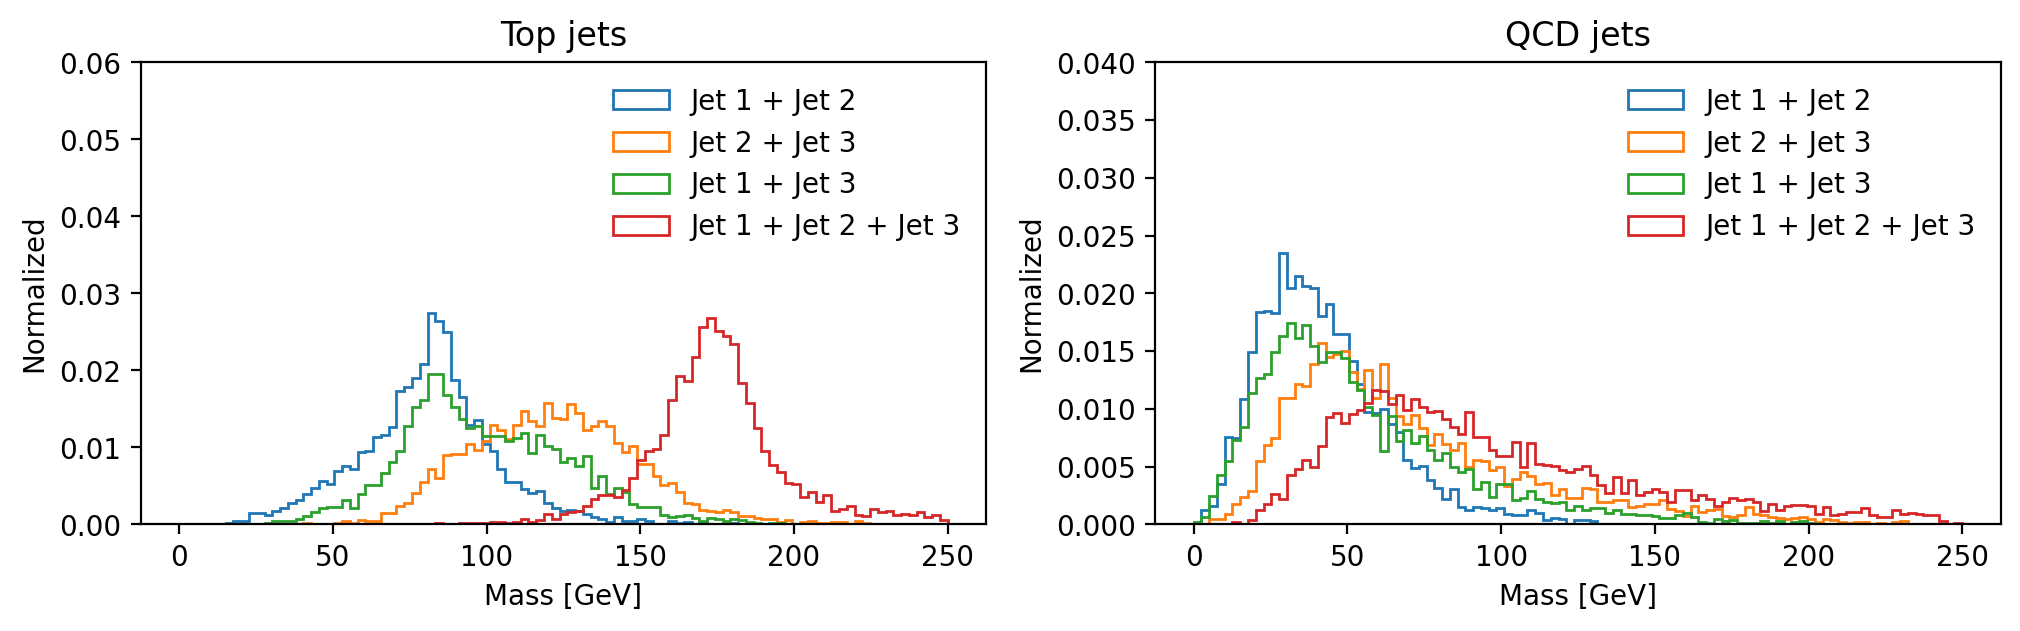

In [8]:
is_top = df["label"] == 1

# the exclusive jets that we get from fastjet are awkward arrays again, so we can
# e.g. add jets together by just using the "+" operator

# let's look at the mass of the three subjets when we add them together
# in different combinations
j1j2 = exclusive_jets_3[:, 0] + exclusive_jets_3[:, 1]
j1j3 = exclusive_jets_3[:, 0] + exclusive_jets_3[:, 2]
j2j3 = exclusive_jets_3[:, 1] + exclusive_jets_3[:, 2]
j1j2j3 = exclusive_jets_3[:, 0] + exclusive_jets_3[:, 1] + exclusive_jets_3[:, 2]

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
hist_kwargs = dict(bins=np.linspace(0, 250, 100), histtype="step", density=True)

ax[0].hist(j1j2.mass[is_top], **hist_kwargs, label="Jet 1 + Jet 2")
ax[0].hist(j2j3.mass[is_top], **hist_kwargs, label="Jet 2 + Jet 3")
ax[0].hist(j1j3.mass[is_top], **hist_kwargs, label="Jet 1 + Jet 3")
ax[0].hist(j1j2j3.mass[is_top], **hist_kwargs, label="Jet 1 + Jet 2 + Jet 3")
# ax.set_yscale("log")
ax[0].legend(frameon=False, ncol=1)
ax[0].set_ylim(top=0.06)
ax[0].set_xlabel("Mass [GeV]")
ax[0].set_title("Top jets")
ax[0].set_ylabel("Normalized")

ax[1].hist(j1j2.mass[~is_top], **hist_kwargs, label="Jet 1 + Jet 2")
ax[1].hist(j2j3.mass[~is_top], **hist_kwargs, label="Jet 2 + Jet 3")
ax[1].hist(j1j3.mass[~is_top], **hist_kwargs, label="Jet 1 + Jet 3")
ax[1].hist(j1j2j3.mass[~is_top], **hist_kwargs, label="Jet 1 + Jet 2 + Jet 3")
# ax.set_yscale("log")
ax[1].legend(frameon=False, ncol=1)
ax[1].set_ylim(top=0.04)
ax[1].set_title("QCD jets")
ax[1].set_xlabel("Mass [GeV]")
ax[1].set_ylabel("Normalized")

plt.show()

In the plot above, we see a peak at around 170 GeV for the top jets 
when we combine all three subjets.

However, we also see a peak around 80 GeV when we combine only two subjets.

The reason for this is that the top quark decays into a $W$ boson and a $b$ quark.

We therefore expect that two of the subjets correspond to the decay products
of the $W$ boson and the third subjet corresponds to the $b$ quark.

### Exercise

Find the subjets that correspond to the $W$ decay products and the $b$ quark and
plot the invariant mass of the $W$ boson candidate (i.e. the mass of the combined
subjets).

Here are a few hints:

- For each jet, we want to look at the three possible combinations of subjets.
  You can use for loops for that, but a more elegant way would be to use
  [`awkward.combinations`](https://awkward-array.org/doc/main/reference/generated/ak.combinations.html?highlight=combinations#ak.combinations)
- Check which of the three combinations has the mass closest to the $W$ boson mass
  You can use [`ak.argmin`](https://awkward-array.org/doc/main/reference/generated/ak.argmin.html?highlight=argmin#ak.argmin) for that.
- Plot the corresponding invariant mass of the $W$ boson candidate.

In [9]:
# ... your code here ...

**Jets in the $\eta$-$\phi$ plane**

In the cell below, we plot the jets in the $\eta$-$\phi$ plane.

Each jet constituent is represented by a dot in the plot and the color of the dot
indicates the subjet index.
The circle indicates the jet circle we obtain from the jet radius.

### Exercise

Think about the following questions:

- What are the differences between the QCD and the top jets in the plots below?
- While using the `antikt_algorithm` for the inclusive jet clustering, we used
    the `kt_algorithm` for the exclusive jet clustering.
    As a result of this, we get an overall circular shape for the inclusive jets
    and a more irregular shape for the exclusive jets.
    Look at the definition of the `antikt_algorithm` and the `kt_algorithm` and
    try to understand why this is the case.
- Some of the plots below show particles on the other side of the plot. This is not
    a bug, but a feature of our coordinate system. Can you explain why this happens?
- Feel free to figure out how to fix these "outliers" in the plots below.


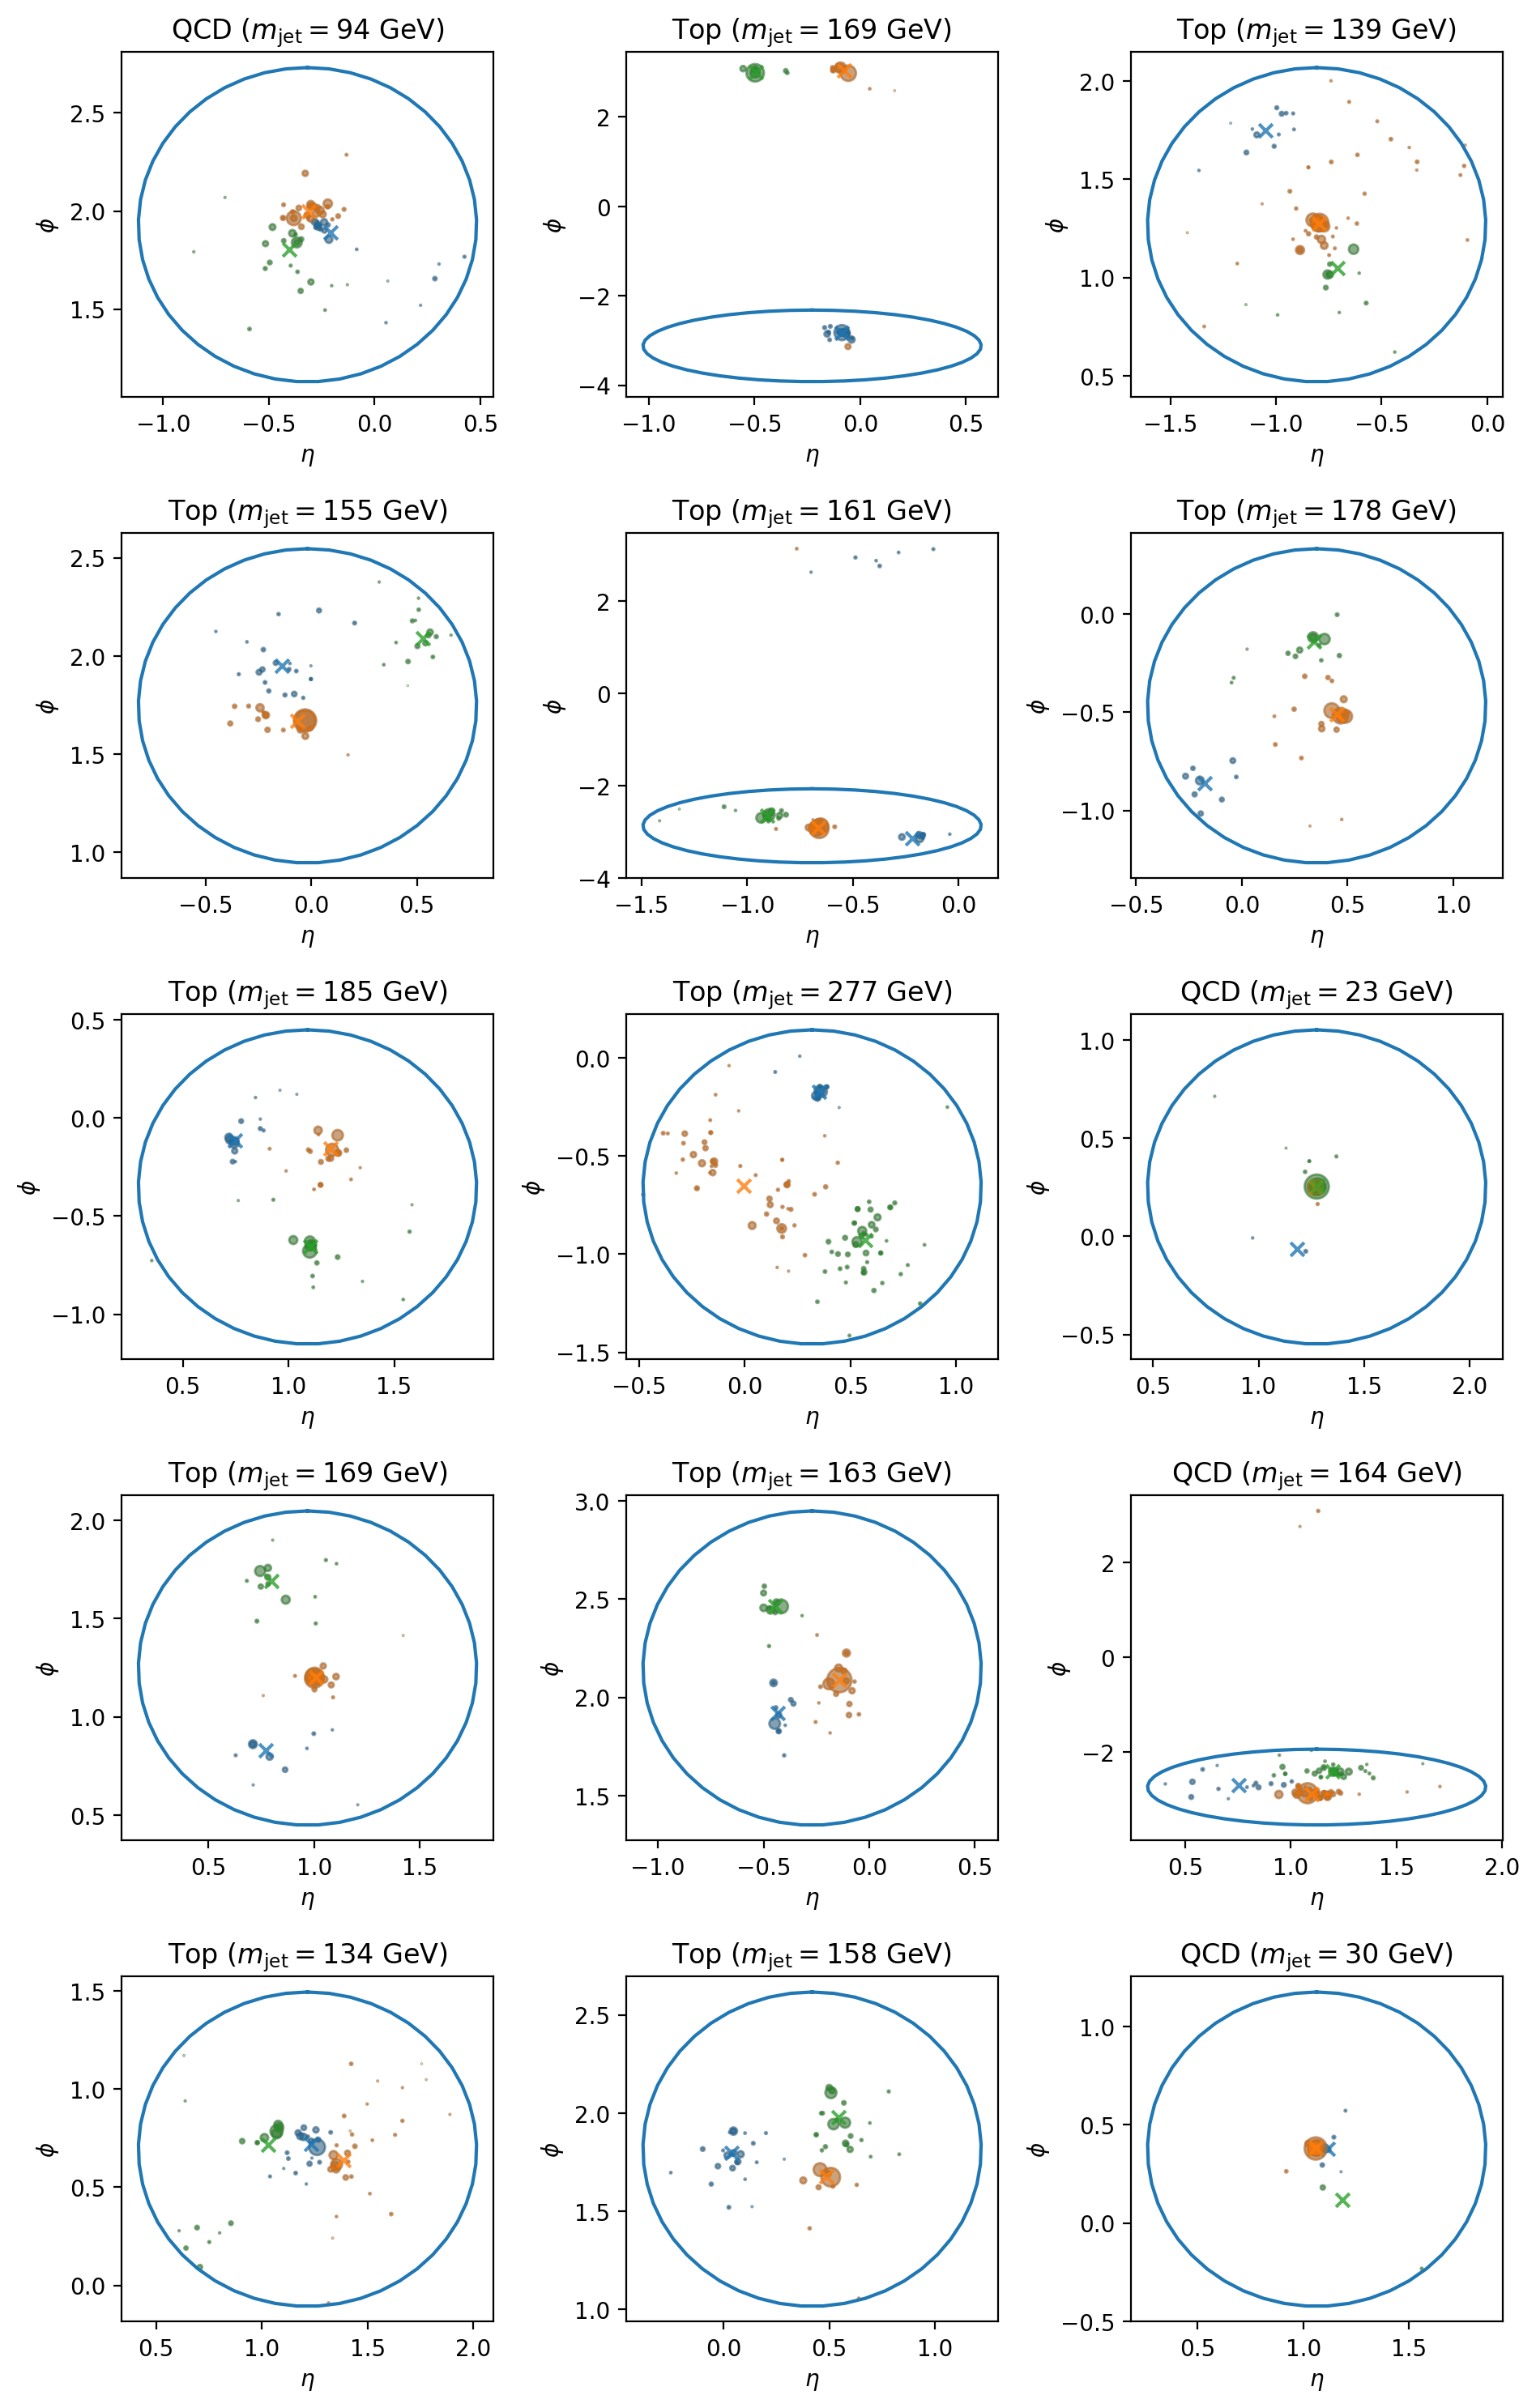

In [10]:
n_jets_plot = 15
n_cols = 3
n_rows = int((n_jets_plot - 0.5) // n_cols + 1)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.2, n_rows*3))
ax = ax.flatten()

np.random.seed(42)
random_jets_to_plot = np.random.choice(len(jet_constituents)-1, n_jets_plot, replace=False)

for i_plot, i_jet in enumerate(random_jets_to_plot):
    kwargs = dict(color=f"k")
    # plot the position of the pseudojets (i.e. jet constituents)
    ax[i_plot].scatter(
        jet_constituents[i_jet].eta, 
        jet_constituents[i_jet].phi,
        s=jet_constituents[i_jet].pt * 0.5, # markersize proportional to pt
        marker="o", alpha=0.3, **kwargs
    )
    # plot the position of the axes of the exclusive jets
    for i, exc_jet in enumerate(exclusive_jets_3[i_jet]):
        kwargs = dict(color=f"C{i}", alpha=0.8, marker="x")
        ax[i_plot].scatter(
            exc_jet.eta, 
            exc_jet.phi,
            **kwargs
        )
    # plot the position of the constituents of the exclusive jets
    for i, exc_jet in enumerate(exclusive_jets_3_const[i_jet]):
        kwargs = dict(color=f"C{i}", alpha=0.3, marker="o")
        ax[i_plot].scatter(
            exc_jet.eta, 
            exc_jet.phi,
            s=exc_jet.pt * 0.5, # markersize proportional to pt
            **kwargs
        )
    # plot the position of the leading pt inclusive jet
    phi = inclusive_jets_antikt_pt_sorted[i_jet].phi[0]
    eta = inclusive_jets_antikt_pt_sorted[i_jet].eta[0]
    mass = inclusive_jets_antikt_pt_sorted[i_jet].mass[0]
    lin = np.linspace(0, 2*np.pi, 50)
    ax[i_plot].plot(
        eta+R*np.sin(lin),
        phi+R*np.cos(lin),
    )
    if is_top[i_jet] == True:
        ax[i_plot].set_title(f"Top ($m_\\mathrm{{jet}}={mass:.0f}$ GeV)")
    else:
        ax[i_plot].set_title(f"QCD ($m_\\mathrm{{jet}}={mass:.0f}$ GeV)")
    ax[i_plot].set_xlabel("$\\eta$")
    ax[i_plot].set_ylabel("$\\phi$")
    # ax[i_plot].set_xlim(-3, 3)
    # ax[i_plot].set_ylim(-np.pi, np.pi)
    
fig.tight_layout()
plt.show()

### Exercise

Now that we have seen the jets in the $\eta$-$\phi$ plane, let's make some plots
to confirm that we are actually looking at the jets that are specified
on [Zenodo](https://zenodo.org/record/2603256).

Check (by making appropriate plots) that the jets we are looking at are indeed
- in the specified $\eta$ range
- have the specified $p_T$ range
- have the specified $R=0.8$ radius

In [11]:
# ... your code here ...